In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as smf
matplotlib.style.use('ggplot')
%matplotlib inline

# Load the data on income and wealth
income_and_wealth = pd.read_excel('data/zh-income-wealth.xlsx')
income_and_wealth.rename(columns={'BFS_NR': 'municipality', 'GEBIET_NAME': 'municipality_name', 'INDIKATOR_JAHR': 'year'}, inplace=True)

# Pick out the series we are interested in : median income
income_and_wealth_grouped = income_and_wealth.groupby('INDIKATOR_ID')
median_income = income_and_wealth_grouped.get_group(316).rename(columns={'INDIKATOR_VALUE' : 'income'})

# Discard the columns we do not care about
median_income = median_income[['municipality', 'year', 'municipality_name', 'income']]

# Load the data on voting
votes = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/partystrengths.csv')
parties = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/parties.csv')
parties.rename(columns={'ID': 'party', 'Abbr_D': 'party_name'}, inplace=True)
parties = parties[['party', 'party_name']]

# Create a frame that merges income data with voting
df = median_income.merge(votes,
    on=['municipality', 'year'], how='inner').merge(parties,
    on='party', how='left')

In [2]:
df

,municipality,year,municipality_name,income,party,support,party_name
0,1,1999,Aeugst a.A.,47700,1,0.247092,FDP
1,1,1999,Aeugst a.A.,47700,2,0.025894,CVP
2,1,1999,Aeugst a.A.,47700,3,0.252853,SP
3,1,1999,Aeugst a.A.,47700,4,0.296906,SVP
4,1,1999,Aeugst a.A.,47700,7,0.014428,EVP
5,1,1999,Aeugst a.A.,47700,8,0.064352,Andere
6,1,1999,Aeugst a.A.,47700,9,0.015142,Kleine Linksparteien
7,1,1999,Aeugst a.A.,47700,13,0.041145,GPS
8,1,1999,Aeugst a.A.,47700,16,0.042188,Kleine Rechtsparteien
9,1,2003,Aeugst a.A.,52100,1,0.207260,FDP


In [3]:
# Compute z-scores for income and party support for easier comparibility accross times
zscore = lambda x: (x - x.mean()) / x.std()
df['z_income'] = pd.Series(df.groupby(['year'])['income'].transform(zscore), index=df.index)
df['z_support'] = pd.Series(df.groupby(['year', 'party'])['support'].transform(zscore), index=df.index)

In [4]:
df

,municipality,year,municipality_name,income,party,support,party_name,z_income,z_support
0,1,1999,Aeugst a.A.,47700,1,0.247092,FDP,0.319470,1.245728
1,1,1999,Aeugst a.A.,47700,2,0.025894,CVP,0.319470,-0.641184
2,1,1999,Aeugst a.A.,47700,3,0.252853,SP,0.319470,1.033298
3,1,1999,Aeugst a.A.,47700,4,0.296906,SVP,0.319470,-1.285255
4,1,1999,Aeugst a.A.,47700,7,0.014428,EVP,0.319470,-1.155562
5,1,1999,Aeugst a.A.,47700,8,0.064352,Andere,0.319470,1.601876
6,1,1999,Aeugst a.A.,47700,9,0.015142,Kleine Linksparteien,0.319470,1.194708
7,1,1999,Aeugst a.A.,47700,13,0.041145,GPS,0.319470,0.061351
8,1,1999,Aeugst a.A.,47700,16,0.042188,Kleine Rechtsparteien,0.319470,-0.224153
9,1,2003,Aeugst a.A.,52100,1,0.207260,FDP,0.410421,0.959167


In [5]:
def plot_relationship_for_year(party, year):
    # Get the data for the party/year
    data = df.groupby('party_name').get_group(party).groupby('year').get_group(year)
    # Create a model
    lm = smf.ols(formula='z_support ~ z_income', data=data).fit()
    preds_input = pd.DataFrame({'z_income': [data.z_income.min(), data.z_income.max()]})
    preds = lm.predict(preds_input)
    # Plot the data
    data.plot(x='z_income', y='z_support', kind='scatter')
    # Plot the model
    plt.plot(preds_input, preds, c='red', linewidth=2)

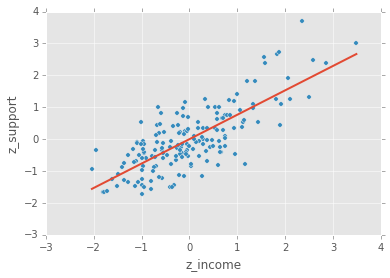

In [6]:
plot_relationship_for_year('FDP', 1999)

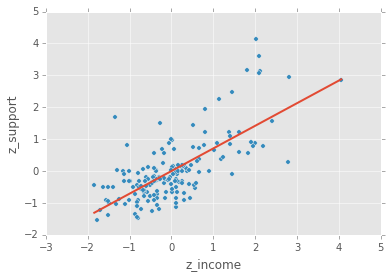

In [7]:
plot_relationship_for_year('FDP', 2011)

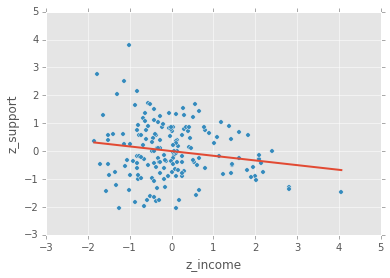

In [8]:
plot_relationship_for_year('SP', 2011)

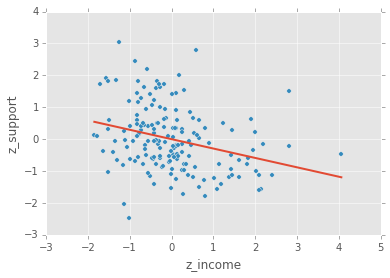

In [9]:
plot_relationship_for_year('SVP', 2011)

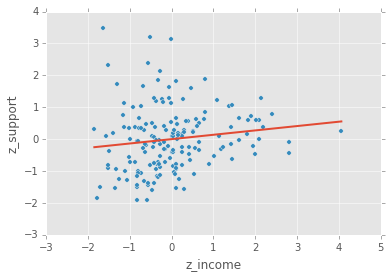

In [10]:
plot_relationship_for_year('CVP', 2011)